In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_picture(name):
    x_path = name
    y_path = './y/sky'+name[7:]
    #print(x_path)
    x = np.load(x_path)
    y = np.load(y_path)
    y_pic = np.zeros_like(x)
    for el in y:
        y_pic[el[0]][el[1]] = 1
    return x, y, y_pic

In [3]:
def get_pic(y):
    y_pic = np.zeros((200, 200))
    for el in y:
        y_pic[el[0]][el[1]] = 1
    return y_pic

In [4]:
x, y, y_pic = get_picture('./x/sky1273.npy')

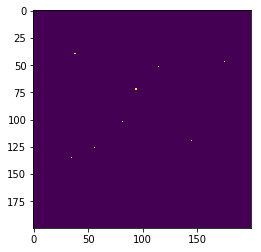

In [5]:
plt.imshow(y_pic)

In [6]:
def get_examples(img, y, h=5,w=5):
    X_good = []
    Y_good = []
    X_bad = []
    Y_bad = []
    H, W = img.shape
    for i in range(h+1, H-2*h):
        for j in range(w + 1, W-2*w):
            piece = img[i-h:i+h+1, j-w:j+w+1]
            ans = y[i][j]
            if ans:
                X_good += [piece]
                Y_good += [ans]
            else:
                X_bad += [piece]
                Y_bad += [ans]
    #print(X_good, X_bad)
    return X_good, Y_good, X_bad, Y_bad

In [7]:
def get_raw_examples(img, h=5,w=5):
    X_good = []
    H, W = img.shape
    for i in range(h+1, H-2*h):
        for j in range(w + 1, W-2*w):
            piece = img[i-h:i+h+1, j-w:j+w+1]
            X_good += [piece]
    return X_good

In [8]:
def get_ans(shape, pred, h=5,w=5):
    ans = []
    H, W = shape
    ind = 0
    for i in range(h+1, H-2*h):
        for j in range(w + 1, W-2*w):
            if pred[ind] > 0.5:
                ans += [[i, j]]
            ind += 1
    return ans

In [9]:
from glob import glob
path = './x/sky*.npy'

In [10]:
def get_dataset(path):
    names = glob(path)
    X = []
    y = []
    X1 = []
    y11 = []
    for el in names:
        x, y1, y_pic = get_picture(el)
        cur_x, cur_y, cur_x1, cur_y1 = get_examples(x, y_pic)
        #print(cur_x[0].shape, cur_y[0].shape)
        #print(cur_x1[0].shape, cur_y1[0].shape)
        X += cur_x
        y += cur_y
        X1 += cur_x1
        y11 += cur_y1
    #print(X.shape)
    return X, y, X1, y11


In [35]:
path = './x/sky*.npy'
names = glob(path)
x_data = []
y_data = []
ypic_data = []
for el in names:
    x, y1, y_pic = get_picture(el)
    x_data += [x]
    y_data += [y]
    ypic_data += [y_pic]
print(len(x_data), len(y_data))

947 947


In [12]:
y_data[1]

array([[ 39,  38],
       [ 47, 175],
       [119, 145],
       [126,  56],
       [ 72,  94],
       [ 51, 115],
       [135,  35],
       [102,  82]])

In [12]:
cnt = 0
for el in sorted(names):
    cnt += 1

In [13]:
cnt

947

In [14]:
%%time 
X, y, X1, y1 = get_dataset(path)

CPU times: user 34.4 s, sys: 2.41 s, total: 36.8 s
Wall time: 36.8 s


In [13]:
len(X), len(X1), len(y), len(y1)

NameError: name 'X' is not defined

In [14]:
%%time
train_x = X + X1[:7534000]
train_y = y + y1[:7534000]

n = len(train_x)
ns = np.arange(n)
from random import shuffle
shuffle(ns)

print(ns[:10])

train_x = np.array(train_x)[ns]
train_y = np.array(train_y)[ns]

NameError: name 'X' is not defined

In [15]:
from random import shuffle
def get_batch_generator(x, y, minibatch_size=32, test=0):
    n = np.arange(len(x))
    #shuffle(n)
    cur = 0
    while cur < len(x):
        #print("kek")
        yield np.array(x[cur:cur+minibatch_size])[:,:,:, np.newaxis], \
        np.array(y[cur:cur+minibatch_size])[:, np.newaxis]
        cur += minibatch_size

In [16]:
gen = get_batch_generator(X, y)

NameError: name 'X' is not defined

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0, 3"

In [18]:
from keras.models import *
from keras.layers import *
import keras

def get_model():
    model = Sequential()
    #model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['binary_accuracy'])
    return model

Using TensorFlow backend.


In [19]:
model = get_model()

In [119]:
model.fit(train_x.reshape((*train_x.shape,1)), 
          train_y.reshape((*train_y.shape,1)),
          validation_split=0.2,
          class_weight = {0:1, 1:1000},
          batch_size=32, epochs=10)

Train on 6033227 samples, validate on 1508307 samples
Epoch 1/10
6033227/6033227 [==============================] - 1618s 268us/step - loss: 16.3255 - binary_accuracy: 0.9990 - val_loss: 15.1958 - val_binary_accuracy: 0.9991
Epoch 2/10
6033120/6033227 [============================>.] - ETA: 0s - loss: 16.3288 - binary_accuracy: 0.9990

KeyboardInterrupt: 

In [123]:
pred = model.predict(train_x.reshape((*train_x.shape,1))[300:500])
ys = train_y[30:50]
print(pred)
print(ys)

[[1.00211325e-27]
 [9.51325640e-21]
 [7.62690252e-21]
 [6.18265806e-27]
 [2.04099852e-24]
 [9.38073738e-31]
 [4.29621916e-33]
 [0.00000000e+00]
 [9.19700352e-34]
 [2.61115873e-28]
 [4.41222953e-20]
 [1.38506025e-17]
 [3.18645274e-31]
 [2.18223817e-20]
 [5.91829434e-25]
 [1.90768606e-19]
 [8.97834533e-32]
 [1.41411443e-24]
 [3.78282375e-23]
 [4.91588218e-24]
 [3.71553219e-17]
 [2.03514833e-20]
 [4.19313147e-32]
 [6.22694366e-27]
 [0.00000000e+00]
 [1.11165143e-22]
 [1.13519727e-26]
 [2.06446508e-33]
 [1.68912954e-27]
 [1.43687196e-23]
 [4.03082566e-36]
 [1.78439552e-28]
 [0.00000000e+00]
 [7.10401107e-29]
 [9.59493709e-20]
 [2.20919550e-24]
 [4.14239172e-28]
 [4.21536068e-24]
 [0.00000000e+00]
 [1.67925288e-22]
 [5.85174824e-27]
 [4.69399714e-21]
 [3.07732371e-25]
 [4.13104852e-34]
 [0.00000000e+00]
 [1.14653694e-29]
 [9.83779911e-30]
 [2.44736535e-22]
 [2.46796541e-20]
 [7.80403182e-25]
 [4.10866399e-29]
 [2.68760651e-23]
 [3.29783178e-20]
 [1.23692994e-20]
 [1.81835402e-21]
 [1.072660

In [129]:
y = []
for i in range(len(xx)):
    print(str(i) + '/' + str(len(xx)))
    pieces = np.array([a.reshape((*a.shape, 1)) for a in get_raw_examples(xx[i])])
    print(np.array(pieces).shape)
    #print(pieces[0])
    pred = model.predict(pieces)
    print(pred.shape)
    ans = get_ans(xx[i].shape, pred)
    y += [ans]
print(y)

0/1
(33856, 11, 11, 1)
(33856, 1)
[[]]


In [35]:
n_ep = 1
from tqdm import tqdm_notebook
from time import clock

for epoch in range(n_ep):
    batch_generator = get_batch_generator(train, test, minibatch_size=32)
    #print([s for s in batch_generator])
    print("epoch #{}".format(epoch))
    scores = []
    errors = []
    #print('r')

    t = 0
    for i, batch in tqdm_notebook(enumerate(batch_generator)):
        #print(len(batch))
        cur_X, cur_y = batch
        #print(X.shape, y.shape)
        if i % 100 == 0:
            
            score = model.test_on_batch(cur_X, cur_y)
            pred = model.predict(cur_X)
            #print(pred.shape, cur_y.shape, pred.sum(), abs(np.array((pred > 0.5), dtype=int) - cur_y).shape)
            #print(abs(np.array((pred > 0.5), dtype=int) == cur_y).mean())
            k = abs(np.array((pred > 0.5), dtype=int) == cur_y)
            scores += [(k[cur_y == 1]).mean()]
            print(len(score))
            errors += [score[0]]
            #print(K.round(pred))
            #with sess.as_default():
            #    print(K.mean(K.equal(cur_y, K.cast(K.round(pred),"int64"))).eval())
            #print(keras.metrics.binary_accuracy(np.array(cur_y, dtype=np.float32), pred).eval())
            #print(score[0])
            #scores.append(score[0])
            #detected = detect(model, test_img_dir=test_dir, test=5000)
            #error = compute_metric(detected, gt, img_shapes)
            #errors.append(error)
            #print()
            #print("Score: {}".format(score))
        if i % 1000 == 0:
            print(i, clock() - t)
        #model.train_on_batch(cur_X, cur_y)
    print("mean_score_by_epoch:", np.average(scores))
    print("mean_func:", np.average(errors))

NameError: name 'train' is not defined

In [20]:
class model:
    def __init__(self, shared=''):
        '''
        This constructor is supposed to initialize data members.
        Use triple quotes for function documentation. 
        '''
        self.X, self.y, self.X1, self.y11 = [], [], [], []

        self.is_trained=False
        #self.shared=shared

    def fit(self, X, y, mod=None):
        '''
        This function should train the model parameters.
        Here we do nothing in this example...
        Args:
            X: Training data matrix of dim num_train_samples * num_feat.
            y: Training label matrix of dim num_train_samples * num_labels.
        Both inputs are numpy arrays.
        For classification, labels could be either numbers 0, 1, ... c-1 for c classe
        or one-hot encoded vector of zeros, with a 1 at the kth position for class k.
        The AutoML format support on-hot encoding, which also works for multi-labels problems.
        Use data_converter.convert_to_num() to convert to the category number format.
        For regression, labels are continuous values.
        '''
        from time import clock
        t = clock()
        for i in range(len(X)):
            x = X[i]
            #print(y[i])
            #break
            y_pic = get_pic(y[i])
            #print(y_pic.sum())
            #break
            cur_x, cur_y, cur_x1, cur_y1 = get_examples(x, y_pic)
            self.X += cur_x
            self.y += cur_y
            self.X1 += cur_x1
            self.y11 += cur_y1
        
        n = len(self.X1)
        ns = np.arange(n)
        from random import shuffle
        shuffle(ns)
        self.X1 = np.array(self.X1)[ns]
        self.y11 = np.array(self.y11)[ns]
        
        self.train_x = self.X + list(self.X1[:10*len(X)])
        self.train_y = self.y + list(self.y11[:10*len(X)])
        print("Dataset", clock()-t)
        n = len(self.train_x)
        ns = np.arange(n)
        from random import shuffle
        shuffle(ns)

        print(ns[:10])

        self.train_x = np.array(self.train_x)[ns]
        self.train_y = np.array(self.train_y)[ns]
        
        if mod is None:
            self.model = get_model()
        else:
            self.model = mod
        
        self.model.fit(self.train_x.reshape((*self.train_x.shape,1)), 
                self.train_y.reshape((*self.train_y.shape,1)),
                #validation_split=0.3,
                class_weight = {0:1, 1:10},
                batch_size=32, epochs=100)
        
        self.is_trained=True
        print("Training is done!")

    def predict(self, X):
        '''
        This function should provide predictions of labels on (test) data.
	In out case X is a dictionary of two fields: Fermi Image and its WCS object.
90
        Make sure that the predicted values are in the correct format for the scoring
        metric. For example, binary classification problems often expect predictions
        in the form of a discriminant value (if the area under the ROC curve it the metric)
        rather that predictions of the class labels themselves. For multi-class or multi-labels
        problems, class probabilities are often expected if the metric is cross-entropy.
        Scikit-learn also has a function predict-proba, we do not require it.
        The function predict eventually can return probabilities.
        '''
        y = []
        for i in range(len(X)):
            print(str(i) + '/' + str(len(X)))
            cur = X[i]
            pieces = get_raw_examples(cur)
            print(np.array(pieces).shape)
            pred = self.model.predict(pieces)
            ans = get_ans(cur.shape, pred)
            y += [ans]
        return y

    def save(self, path="./"):
        pickle.dump(self, open(path + '_model.pickle', "wb"), 2) 

    def load(self, path="./"):
        print(path)
        modelfile = path + '_model.pickle'
        print(modelfile)
        if os.path.isfile(modelfile):
            with open(modelfile, 'rb') as f:
                self = pickle.load(f)
            print("Model reloaded from: " + modelfile)
        return self

In [21]:
m = model()

In [22]:
m.fit(x_data, y_data)

Dataset 137.493594
[11284 14961 13302  6778  5842  5759  1029 15612 12800 11361]
Epoch 1/100
17046/17046 [==============================] - 6s 376us/step - loss: 2.0317 - binary_accuracy: 0.4439
Epoch 2/100
17046/17046 [==============================] - 4s 209us/step - loss: 1.7703 - binary_accuracy: 0.4444
Epoch 3/100
17046/17046 [==============================] - 4s 210us/step - loss: 1.7618 - binary_accuracy: 0.4444
Epoch 4/100
17046/17046 [==============================] - 4s 211us/step - loss: 1.8171 - binary_accuracy: 0.4450
Epoch 5/100
17046/17046 [==============================] - 3s 204us/step - loss: 1.7498 - binary_accuracy: 0.4444
Epoch 6/100
17046/17046 [==============================] - 4s 208us/step - loss: 1.7450 - binary_accuracy: 0.4444
Epoch 7/100
17046/17046 [==============================] - 4s 221us/step - loss: 1.7397 - binary_accuracy: 0.4444
Epoch 8/100
17046/17046 [==============================] - 3s 204us/step - loss: 1.7338 - binary_accuracy: 0.4444
Epoch 9

17046/17046 [==============================] - 4s 210us/step - loss: 0.4601 - binary_accuracy: 0.8825
Epoch 72/100
17046/17046 [==============================] - 4s 216us/step - loss: 0.4596 - binary_accuracy: 0.8802
Epoch 73/100
17046/17046 [==============================] - 4s 207us/step - loss: 0.4626 - binary_accuracy: 0.8818
Epoch 74/100
17046/17046 [==============================] - 4s 209us/step - loss: 0.4514 - binary_accuracy: 0.8845
Epoch 75/100
17046/17046 [==============================] - 4s 214us/step - loss: 0.4827 - binary_accuracy: 0.8767
Epoch 76/100
17046/17046 [==============================] - 4s 212us/step - loss: 0.4774 - binary_accuracy: 0.8783
Epoch 77/100
17046/17046 [==============================] - 4s 218us/step - loss: 0.4630 - binary_accuracy: 0.8800
Epoch 78/100
17046/17046 [==============================] - 4s 213us/step - loss: 0.4673 - binary_accuracy: 0.8778
Epoch 79/100
17046/17046 [==============================] - 4s 212us/step - loss: 0.4559 - bi

In [44]:
trained = m1.model


In [45]:
m1 = model()
m1.fit(x_data, y_data, trained)


Dataset 153.90384600000016
[21308  3291 53302 36331 16883  6106 10744  5772 50309 24783]
Epoch 1/100
54926/54926 [==============================] - 12s 215us/step - loss: 2.1629 - binary_accuracy: 0.3134
Epoch 2/100
54926/54926 [==============================] - 13s 231us/step - loss: 2.0998 - binary_accuracy: 0.3130
Epoch 3/100
54926/54926 [==============================] - 13s 231us/step - loss: 2.0889 - binary_accuracy: 0.3112
Epoch 4/100
54926/54926 [==============================] - 12s 219us/step - loss: 2.0822 - binary_accuracy: 0.3083
Epoch 5/100
54926/54926 [==============================] - 12s 217us/step - loss: 2.0490 - binary_accuracy: 0.3185
Epoch 6/100
54926/54926 [==============================] - 12s 225us/step - loss: 2.0547 - binary_accuracy: 0.3145
Epoch 7/100
54926/54926 [==============================] - 12s 226us/step - loss: 2.0375 - binary_accuracy: 0.3254
Epoch 8/100
54926/54926 [==============================] - 13s 233us/step - loss: 2.0474 - binary_accuracy

54926/54926 [==============================] - 12s 215us/step - loss: 1.8507 - binary_accuracy: 0.3734
Epoch 71/100
54926/54926 [==============================] - 13s 230us/step - loss: 1.8045 - binary_accuracy: 0.3826
Epoch 72/100
54926/54926 [==============================] - 13s 245us/step - loss: 1.8242 - binary_accuracy: 0.3781
Epoch 73/100
54926/54926 [==============================] - 13s 245us/step - loss: 1.8565 - binary_accuracy: 0.3731
Epoch 74/100
54926/54926 [==============================] - 13s 236us/step - loss: 1.8352 - binary_accuracy: 0.3755
Epoch 75/100
54926/54926 [==============================] - 14s 251us/step - loss: 1.8110 - binary_accuracy: 0.3798
Epoch 76/100
54926/54926 [==============================] - 14s 247us/step - loss: 1.8227 - binary_accuracy: 0.3827
Epoch 77/100
54926/54926 [==============================] - 14s 251us/step - loss: 1.8061 - binary_accuracy: 0.3846
Epoch 78/100
54926/54926 [==============================] - 14s 246us/step - loss: 1.

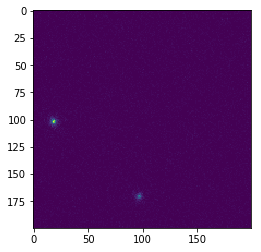

In [46]:
plt.imshow(xx[0])

In [45]:
y = []
xx = [x_data[125]]
for i in range(len(xx)):
    print(str(i) + '/' + str(len(xx)))
    pieces = np.array([a.reshape((*a.shape, 1)) for a in get_raw_examples(xx[i])])
    print(np.array(pieces).shape)
    #print(pieces[0])
    z, t, z1, t1 = get_examples(xx[i], ypic_data[i])
    z += z1
    t += t1
    
    print(len(z), len(t))
    pred = m.model.predict(pieces)
    print(pred.shape, ypic_data[125].shape)
    print(((pred>0.5).ravel()==t).sum()/len(t))
    ans = get_ans(xx[i].shape, pred)
    y += [ans]
#print(y)

0/1
(33856, 11, 11, 1)
33856 33856
(33856, 1) (200, 200)
0.02841446124763705


In [ ]:
y

In [33]:
print((pred>0.999999).sum())

855


In [62]:
np.where(pred>0.9999999)

(array([ 3192,  4729, 10857, 15957, 24306, 26245]), array([0, 0, 0, 0, 0, 0]))